# Reed-Solomon Codes for Quantum Error Correction

This notebook focuses on implementing Reed-Solomon (RS) codes for quantum error correction in the context of biased-noise qubits.

## Context

For this QEC challenge with Alice and Bob, we're working with **biased qubits** where the hardware handles phase flip errors. Therefore, we only need to implement QEC codes for **bit flip errors**.

Reed-Solomon codes are maximum-distance separable (MDS) codes that achieve the Singleton bound:
$$d = n - k + 1$$

where:
- **$n$**: Block length (total number of symbols)
- **$k$**: Dimension (number of information symbols)
- **$d$**: Minimum distance

RS codes operate over finite fields $GF(2^m)$, and we'll map them to binary representations for quantum implementation.

## Setup: Binary Image Representation

To use Reed-Solomon codes over $GF(2^m)$ in a quantum setting, we need to map each field element to its binary matrix representation. This allows us to convert the parity check matrix $H$ and generator matrix $G$ from $GF(2^m)$ to binary matrices.

**Key Concept**: Each element in $GF(2^m)$ can be represented as an $m \times m$ binary matrix that describes how multiplication by that element acts on the field's basis. When we construct the binary parity check matrix $H_{bin}$, each $GF(2^m)$ entry in the original $H$ becomes an $m \times m$ block, resulting in a matrix of size $(n-k) \times m$ rows by $n \times m$ columns.

In [1]:
import galois
import numpy as np
import stim
import pymatching
import sinter
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_binary_image(element, field):
    """Maps a GF(2^m) element to its m x m binary matrix representation."""
    m = field.degree
    # We generate the matrix by applying the element to the basis {1, a, a^2...}
    # and extracting the vector representation.
    return np.stack([
        (element * field.primitive_element**i).vector() 
        for i in range(m)
    ], axis=1).astype(np.int32)

## Circuit Generation for RS Codes

We'll generate a Stim circuit that implements the Reed-Solomon code as a CSS-style quantum error-correcting code. Since we're only dealing with bit-flip errors, we use Z-stabilizers (which detect X errors).

**Circuit Structure**:
- **Data qubits**: $n \times m$ physical qubits encoding the quantum information
- **Ancilla qubits**: $(n-k) \times m$ ancilla qubits for syndrome measurement
- **Stabilizers**: Each row of $H_{bin}$ defines a Z-stabilizer that checks a subset of data qubits
- **Measurement**: Z-stabilizers are measured by preparing ancillas in $|+\rangle$, applying controlled-Z gates, then measuring in the X-basis

Circuit built: 21 physical qubits, 6 stabilizers.
Code distance: d = 3


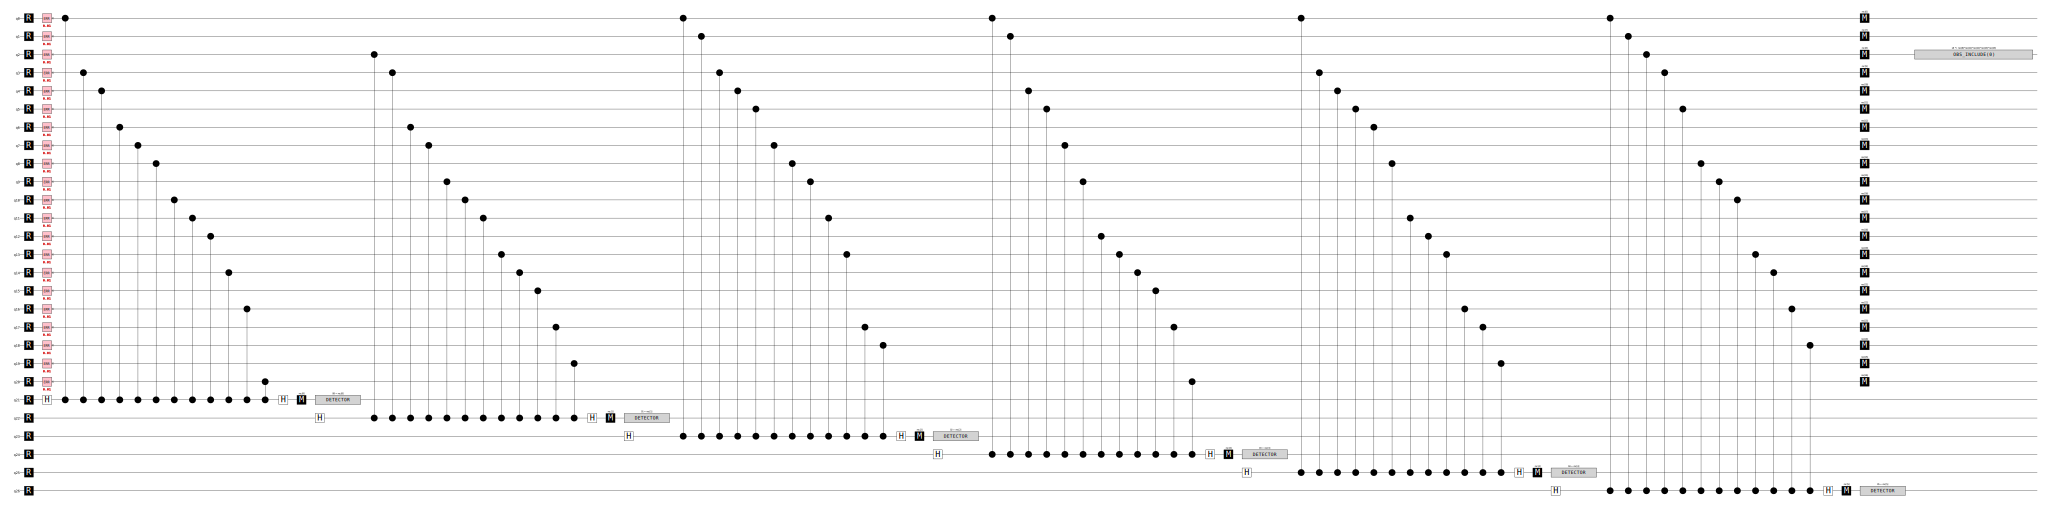

In [2]:
def generate_biased_rs_circuit(n, k, m, p_bitflip):
    """
    Generate a Stim circuit for a Reed-Solomon code adapted for biased-noise qubits.
    
    **Circuit Implementation**: Uses CZ gates with Hadamards (equivalent to CNOT)
    - Prepares ancilla in |+⟩ state (H gate)
    - Applies CZ gates between ancilla and data qubits
    - Measures ancilla in X-basis (H then M)
    - This measures the parity (Z-stabilizer) of the data qubits
    
    Parameters:
    - n: Block length (number of symbols in GF(2^m))
    - k: Dimension (number of information symbols)
    - m: Field extension degree (GF(2^m))
    - p_bitflip: Physical bit-flip error rate
    
    Returns:
    - circuit: Stim circuit implementing the RS code
    - H_bin: Binary parity check matrix (mod 2)
    - G_bin: Binary generator matrix (mod 2)
    """
    # 1. Generate the RS code
    rs = galois.ReedSolomon(n, k, systematic=True)
    H_gf = rs.H
    G_gf = rs.G
    
    # 2. Map GF matrices to Binary Image (Block Matrices)
    # H_bin shape: ((n-k)*m, n*m)
    H_bin = np.block([[get_binary_image(cell, rs.field) for cell in row] for row in H_gf])
    # G_bin shape: (k*m, n*m)
    G_bin = np.block([[get_binary_image(cell, rs.field) for cell in row] for row in G_gf])
    
    # Convert to binary (mod 2) to ensure proper binary representation
    H_bin = (H_bin % 2).astype(np.int32)
    G_bin = (G_bin % 2).astype(np.int32)
    
    # 3. Build Stim Circuit
    c = stim.Circuit()
    n_phys = n * m
    n_stabs = H_bin.shape[0]
    
    data = list(range(n_phys))
    ancillas = list(range(n_phys, n_phys + n_stabs))
    
    c.append("R", data + ancillas)
    
    # Add noise only to data qubits (since we're checking bit-flips)
    c.append("X_ERROR", data, p_bitflip)
    
    # Z-stabilizer Measurements (checking for X errors)
    # H|0⟩ = |+⟩, then CZ measures parity, then H converts back to computational basis
    for i in range(n_stabs):
        anc = ancillas[i]
        # Get unique qubit indices to avoid duplicate gates
        qubits_to_check = np.unique(np.where(H_bin[i] > 0)[0])
        c.append("H", [anc])
        for q in qubits_to_check:
            # CZ + Hadamards on ancilla = CNOT(data_q, ancilla)
            c.append("CZ", [anc, int(q)])
        c.append("H", [anc])
        c.append("M", [anc])
        c.append("DETECTOR", [stim.target_rec(-1)])
    
    # Final measurement of data qubits to verify the logical state
    c.append("M", data)
    
    # 4. Logical Observable: The first row of G_bin
    # This represents the first logical X operator of the code
    l_x_indices = np.unique(np.where(G_bin[0] > 0)[0])
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n_phys + i) for i in l_x_indices], 0)
    
    return c, H_bin, G_bin

# Example: (7, 5, 3) RS code over GF(8)
n, k, m = 7, 5, 3
circuit, H_matrix, G_bin = generate_biased_rs_circuit(n, k, m, 0.01)
print(f"Circuit built: {n*m} physical qubits, {(n-k)*m} stabilizers.")
print(f"Code distance: d = {n - k + 1}")
circuit.diagram('timeline-svg')

## Decoding Strategies

We'll compare two decoding approaches:

1. **Maximum Likelihood Estimation (MLE)**: Brute-force search for the most likely error pattern given the syndrome. This searches error patterns up to weight $\lfloor (d-1)/2 \rfloor + 1$ and chooses the most probable logical outcome.

2. **PyMatching (MWPM)**: Minimum-weight perfect matching decoder that constructs a graph from the detector error model and finds the minimum-weight error chain connecting syndrome defects. This is optimal for surface codes but suboptimal for dense codes like RS codes.

In [3]:
def brute_force_mle_decode(syndromes, H_bin, L_bin, p, d):
    """
    Brute-force MLE decoder for small codes.
    Checks error patterns up to weight (d-1)//2 + 1.
    
    Parameters:
    - syndromes: Array of syndrome vectors
    - H_bin: Binary parity check matrix
    - L_bin: Binary logical operator (first row of generator)
    - p: Physical error rate
    - d: Code distance
    
    Returns:
    - predictions: Array of logical predictions (0 or 1)
    """
    num_shots, num_qubits = syndromes.shape[0], H_bin.shape[1]
    predictions = np.zeros((num_shots, 1), dtype=np.bool_)
    log_p = np.log(p / (1 - p)) if p > 0 else -100
    max_w = (d - 1) // 2 + 1 
    
    for i in range(num_shots):
        syn = syndromes[i]
        if not np.any(syn): 
            continue  # No error, logical is 0
        
        prob_L0, prob_L1, found = 0.0, 0.0, False
        for w in range(1, max_w + 1):
            for combo in itertools.combinations(range(num_qubits), w):
                e = np.zeros(num_qubits, dtype=np.int32)
                e[list(combo)] = 1
                if np.array_equal((H_bin @ e) % 2, syn):
                    found = True
                    p_val = np.exp(w * log_p)
                    if (L_bin @ e) % 2 == 0: 
                        prob_L0 += p_val
                    else: 
                        prob_L1 += p_val
            if found: 
                break  # Found lowest weight coset leaders
        predictions[i] = 1 if prob_L1 > prob_L0 else 0
    return predictions

In [4]:
def run_rs_pymatching_experiment(circuit, num_shots=100_000):
    """
    Decodes the RS code using MWPM (PyMatching) for comparison.
    Note: For dense codes, we must ignore decomposition failures during DEM generation.
    """
    # 1. Sample the circuit
    sampler = circuit.compile_detector_sampler()
    dets, actual_observables = sampler.sample(num_shots, separate_observables=True)

    # 2. Generate the Detector Error Model (DEM)
    # Reed-Solomon codes have high-degree checks, so we use ignore_decomposition_failures
    error_model = circuit.detector_error_model(
        decompose_errors=True, 
        ignore_decomposition_failures=True
    )
    
    # 3. Initialize Matcher
    matcher = pymatching.Matching.from_detector_error_model(error_model)

    # 4. Decode
    print(f"Decoding {num_shots} shots via PyMatching (MWPM)...")
    predicted_observables = matcher.decode_batch(dets)
    
    # 5. Calculate Errors
    num_errors = np.count_nonzero(np.any(predicted_observables ^ actual_observables, axis=1))
    
    print(f"--- Results (PyMatching) ---")
    print(f"Logical Errors: {num_errors} / {num_shots}")
    print(f"Logical Error Rate: {num_errors / num_shots:.5f}")
    return num_errors / num_shots

In [5]:
def run_rs_mle_experiment(circuit, H_bin, L_bin, p_bitflip, d, num_shots=10_000):
    """
    Run MLE decoding experiment on RS code.
    """
    sampler = circuit.compile_detector_sampler()
    dets, actual_obs = sampler.sample(num_shots, separate_observables=True)
    
    # Run MLE Decoder
    print(f"Decoding {num_shots} shots via Brute-Force MLE...")
    predicted_obs = brute_force_mle_decode(dets, H_bin, L_bin, p_bitflip, d)
    
    num_errors = np.count_nonzero(np.any(predicted_obs ^ actual_obs, axis=1))
    
    print(f"--- Results (MLE) ---")
    print(f"Logical Errors: {num_errors} / {num_shots}")
    print(f"Logical Error Rate: {num_errors / num_shots:.5f}")
    return num_errors / num_shots

## Example: Testing a Small RS Code

Let's test the (7, 5, 3) RS code over GF(8) with both decoders:

In [6]:

# Setup parameters
n, k, m, p = 7, 5, 3, 0.01
rs_circuit, H_bin, G_bin = generate_biased_rs_circuit(n, k, m, p)
d = n - k + 1  # Code distance
L_bin = G_bin[0]  # First logical operator

print(f"RS Code Parameters:")
print(f"  Block length: n = {n}")
print(f"  Dimension: k = {k}")
print(f"  Field: GF(2^{m})")
print(f"  Distance: d = {d}")
print(f"  Physical qubits: {n*m}")
print(f"  Stabilizers: {(n-k)*m}")

# Print the stabilizers
print(f"\nStabilizers (Z-stabilizers for X error detection):")
for i in range(H_bin.shape[0]):
    qubits = np.where(H_bin[i] > 0)[0].tolist()
    print(f"  S_{i+1}: Z{qubits}")

# Run experiments
print("\n" + "="*50)
mle_rate = run_rs_mle_experiment(rs_circuit, H_bin, L_bin, p, d, num_shots=10_000)
print("\n" + "="*50)
pymatching_rate = run_rs_pymatching_experiment(rs_circuit, num_shots=100_000)

RS Code Parameters:
  Block length: n = 7
  Dimension: k = 5
  Field: GF(2^3)
  Distance: d = 3
  Physical qubits: 21
  Stabilizers: 6

Stabilizers (Z-stabilizers for X error detection):
  S_1: Z[0, 3, 4, 6, 7, 8, 10, 11, 12, 14, 16, 20]
  S_2: Z[2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19]
  S_3: Z[0, 1, 3, 4, 5, 7, 8, 9, 11, 13, 17, 18]
  S_4: Z[0, 1, 4, 5, 7, 9, 12, 13, 14, 15, 17, 20]
  S_5: Z[0, 3, 4, 5, 6, 8, 11, 12, 13, 16, 17, 19]
  S_6: Z[0, 1, 2, 3, 5, 8, 9, 10, 13, 14, 16, 18]

Decoding 10000 shots via Brute-Force MLE...
--- Results (MLE) ---
Logical Errors: 73 / 10000
Logical Error Rate: 0.00730

Decoding 100000 shots via PyMatching (MWPM)...
--- Results (PyMatching) ---
Logical Errors: 3317 / 100000
Logical Error Rate: 0.03317


## Comprehensive Performance Analysis

Let's run a more comprehensive experiment comparing MLE and PyMatching across different error rates and code parameters.

**Note on RS Code Limitations**: 
- Reed-Solomon codes are not ideal for quantum error correction due to their dense structure
- The binary image transformation creates very high-weight stabilizers
- PyMatching (designed for sparse codes) struggles with these dense codes
- MLE is computationally expensive and may not scale well
- However, this analysis documents the behavior and limitations of RS codes in the quantum setting


Running d=3 experiment (n=7, k=5, m=3)...
  Physical qubits: 21, Stabilizers: 6, Logical qubits: 15


d=3: 100%|██████████| 10/10 [02:14<00:00, 13.41s/it]



Running d=5 experiment (n=7, k=3, m=3)...
  Physical qubits: 21, Stabilizers: 12, Logical qubits: 9


d=5: 100%|██████████| 10/10 [11:35<00:00, 69.56s/it] 


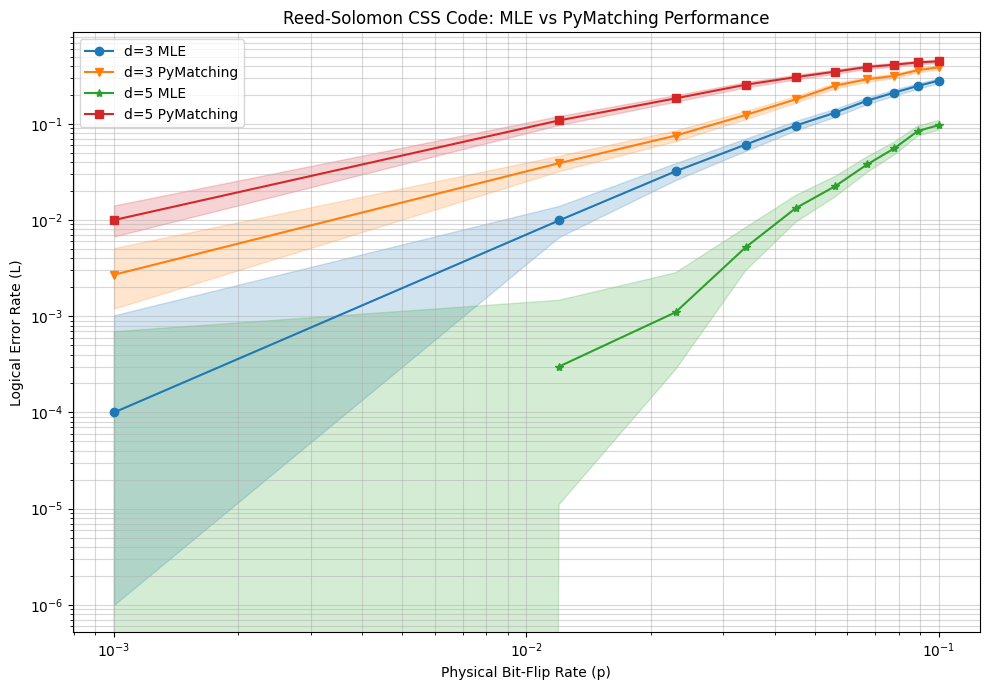

In [7]:
def generate_rs_css_circuit_cx(n, k, m, p):
    """
    Generate a Stim circuit for Reed-Solomon code using CNOT gates directly.
    
    **How it works**:
    1. Creates a Reed-Solomon code over GF(2^m) with parameters (n, k)
    2. Converts the GF(2^m) parity check matrix H to binary form H_bin
    3. Each row of H_bin defines a Z-stabilizer (checks for X errors)
    4. For each stabilizer, applies CNOT gates from data qubits to ancilla
    5. Measures ancilla to get syndrome bits
    
    **Fix for duplicate qubits**: The binary image matrices can have entries > 1,
    so we convert to mod-2 and use np.unique() to ensure each qubit appears only once.
    """
    rs = galois.ReedSolomon(n, k, systematic=True)
    H_bin = np.block([[get_binary_image(cell, rs.field) for cell in row] for row in rs.H])
    G_bin = np.block([[get_binary_image(cell, rs.field) for cell in row] for row in rs.G])
    
    # Convert to binary (mod 2) to handle any values > 1 from binary image
    H_bin = (H_bin % 2).astype(np.int32)
    G_bin = (G_bin % 2).astype(np.int32)
    
    c = stim.Circuit()
    n_phys, n_stabs = n * m, H_bin.shape[0]
    data, anc = list(range(n_phys)), list(range(n_phys, n_phys + n_stabs))
    
    c.append("R", data + anc)
    c.append("X_ERROR", data, p)
    
    # Z-stabilizers using CX (Data controls, Ancilla targets)
    for i in range(n_stabs):
        # Get unique qubit indices to avoid duplicate CX gates
        indices = np.unique(np.where(H_bin[i] > 0)[0])
        for q in indices:
            # CX from Data to Ancilla for bit-flip detection
            # This measures the parity of data qubits into the ancilla
            c.append("CX", [int(q), anc[i]])
        c.append("M", [anc[i]])
        c.append("DETECTOR", [stim.target_rec(-1)])
        
    c.append("M", data)
    l_x_indices = np.unique(np.where(G_bin[0] > 0)[0])
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n_phys + i) for i in l_x_indices], 0)
    
    return c, H_bin, G_bin[0]

def run_rs_experiment_safe():
    """
    Run comprehensive RS code experiments with error handling.
    
    **Experiment Design**:
    - Tests multiple code configurations (n, k, d) where d = n - k + 1
    - Varies physical error rates to see threshold behavior
    - Compares MLE vs PyMatching decoders
    - Handles PyMatching failures gracefully (dense codes can cause issues)
    
    **Why RS codes are challenging**:
    - Dense parity check matrices (high-weight stabilizers)
    - PyMatching works best on sparse codes (like surface codes)
    - MLE is computationally expensive for large codes
    - Binary image transformation creates very dense structures
    """
    # Test various code parameters: (n, k, d) where d = n - k + 1
    # Note: Some configurations may not work well due to code limitations
    configs = [(7, 5, 3), (7, 3, 5)]  # Start with known working configs
    error_rates = np.linspace(0.001, 0.1, 10)
    num_shots = 10_000
    all_stats = []
    
    for n, k, d in configs:
        m = 3  # Field extension degree (GF(8))
        print(f"\nRunning d={d} experiment (n={n}, k={k}, m={m})...")
        print(f"  Physical qubits: {n*m}, Stabilizers: {(n-k)*m}, Logical qubits: {k*m}")
        
        for p in tqdm(error_rates, desc=f"d={d}"):
            try:
                circuit, H_bin, L_bin = generate_rs_css_circuit_cx(n, k, m, p)
                sampler = circuit.compile_detector_sampler()
                dets, actual_obs = sampler.sample(num_shots, separate_observables=True)
                
                # 1. PyMatching with Failure Handling
                # PyMatching can fail on dense codes, so we handle exceptions
                dem = circuit.detector_error_model(
                    decompose_errors=True, 
                    ignore_decomposition_failures=True
                )
                matcher = pymatching.Matching.from_detector_error_model(dem)
                
                pm_predictions = []
                for shot_idx in range(num_shots):
                    try:
                        # Attempt decoding single shot
                        prediction = matcher.decode(dets[shot_idx])
                        pm_predictions.append(prediction)
                    except (ValueError, RuntimeError):
                        # If matching fails, provide no correction (prediction = 0)
                        pm_predictions.append([0])
                
                pm_predictions = np.array(pm_predictions)
                pm_err = np.count_nonzero(np.any(pm_predictions ^ actual_obs, axis=1))
                
                all_stats.append(sinter.TaskStats(
                    strong_id=f"PM_d{d}_p{p}",
                    decoder='pymatching',
                    shots=num_shots, 
                    errors=pm_err, 
                    json_metadata={'d': d, 'p': p, 'label': f"d={d} PyMatching"}
                ))
                
                # 2. MLE (Always finds a best-guess coset)
                # MLE searches error patterns and chooses most likely logical outcome
                mle_predictions = brute_force_mle_decode(dets, H_bin, L_bin, p, d)
                mle_err = np.count_nonzero(np.any(mle_predictions ^ actual_obs, axis=1))
                
                all_stats.append(sinter.TaskStats(
                    strong_id=f"MLE_d{d}_p{p}",
                    decoder='mle_bruteforce',
                    shots=num_shots, 
                    errors=mle_err, 
                    json_metadata={'d': d, 'p': p, 'label': f"d={d} MLE"}
                ))
            except Exception as e:
                print(f"  Error at p={p}: {e}")
                continue
                
    return all_stats

# Run comprehensive experiment
stats = run_rs_experiment_safe()

# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
sinter.plot_error_rate(
    ax=ax,
    stats=stats,
    x_func=lambda s: s.json_metadata['p'],
    group_func=lambda s: s.json_metadata['label']
)
ax.set_title("Reed-Solomon CSS Code: MLE vs PyMatching Performance")
ax.set_xlabel("Physical Bit-Flip Rate (p)")
ax.set_ylabel("Logical Error Rate (L)")
ax.loglog()
ax.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()